Imports and Initial Setup

In [2]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import ipaddress

# Configure the display options
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load the data
data = pd.read_csv('../../src/data/Fraud_Data.csv')

1. See the Size, Head, and Descriptions of the Data 

    Load the data and explore its size, head, and basic descriptions.

In [3]:
# Check the size of the data
print("Size of the data:")
print(data.shape)

# Display the first few rows of the data
print("\nHead of the data:")
data.head()

Size of the data:
(151112, 11)

Head of the data:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
# Display the basic statistical descriptions of the data
print("\nDescription of the data:")
data.describe()


Description of the data:


,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


2. Handle Missing Values

In [5]:
# Check for missing values
print("\nMissing values in each column:")
data.isnull().sum()


Missing values in each column:


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

3. Data Cleaning

Check for Duplicates and White Spaces

In [6]:
# Check for duplicate rows
print("\nNumber of duplicate rows:")
print(data.duplicated().sum())

# Check for white spaces in column names
print("\nColumn names before handling white spaces:", data.columns.tolist())

# Check for white spaces in string data (if applicable)
for column in data.select_dtypes(include=['object']).columns:
    if data[column].str.contains(' ').any():
        print(f"White spaces found in column: {column}")
    else:
        print(f"No white spaces found in column: {column}")


Number of duplicate rows:
0

Column names before handling white spaces: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']
White spaces found in column: signup_time
White spaces found in column: purchase_time
No white spaces found in column: device_id
No white spaces found in column: source
No white spaces found in column: browser
No white spaces found in column: sex


Handle white spaces

In [7]:
# Handle white spaces in column names
data.columns = data.columns.str.strip()

# Handle white spaces in string data (if applicable)
for column in data.select_dtypes(include=['object']).columns:
    data[column] = data[column].str.strip()

Check and Correct Data Types

In [8]:
# Check data types
print(data.dtypes)

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object


Correct data types if needed

In [9]:
# Correct data types if needed
data['user_id'] = data['user_id'].astype(int)
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['purchase_value'] = data['purchase_value'].astype(float)
data['device_id'] = data['device_id'].astype(str)
data['source'] = data['source'].astype(str)
data['browser'] = data['browser'].astype(str)
data['sex'] = data['sex'].astype(str)
data['age'] = data['age'].astype(int)
data['ip_address'] = data['ip_address'].astype(float)
data['class'] = data['class'].astype(int)

# Display the data types after correction
print("\nData types after correction:")
print(data.dtypes)



Data types after correction:
user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value           float64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object


Identify outliers

Percentage of total with 'class' value 1 (fraudulent transaction): 9.36%
Number of outliers in 'purchase_value': 1067
Number of outliers with 'class' value 1 (fraudulent transaction): 99
Percentage of outliers with 'class' value 1 (fraudulent transaction): 9.28%
Percentage of fraudulent outliers with respect to the total data: 0.07%


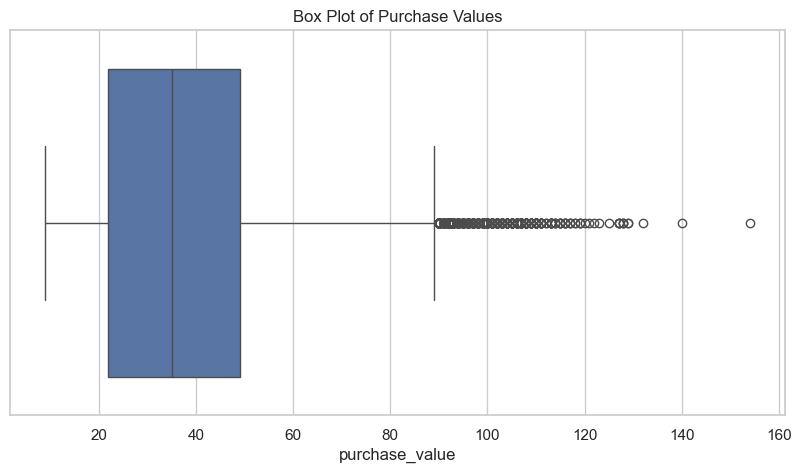

In [10]:
# Calculate the IQR for the 'purchase_value' column
Q1 = data['purchase_value'].quantile(0.25)
Q3 = data['purchase_value'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = data[(data['purchase_value'] < (Q1 - 1.5 * IQR)) | (data['purchase_value'] > (Q3 + 1.5 * IQR))]

# Count the number of outliers
num_outliers = outliers.shape[0]

# Define the total number of data points
total_data_points = data.shape[0]

# Calculate the percentage of total transactions that are fraudulent
class_percentages = data['class'].value_counts(normalize=True) * 100

# Count the number of outliers with 'class' value 1
num_fraudulent_outliers = outliers[outliers['class'] == 1].shape[0]

# Calculate the percentage of outliers with 'class' value 1
percentage_fraudulent_outliers = (num_fraudulent_outliers / num_outliers) * 100

# Calculate the percentage of fraudulent outliers with respect to the total data
percentage_fraudulent_outliers_total = (num_fraudulent_outliers / total_data_points) * 100

# Print the results
print(f"Percentage of total with 'class' value 1 (fraudulent transaction): {class_percentages[1]:.2f}%")
print(f"Number of outliers in 'purchase_value': {num_outliers}")
print(f"Number of outliers with 'class' value 1 (fraudulent transaction): {num_fraudulent_outliers}")
print(f"Percentage of outliers with 'class' value 1 (fraudulent transaction): {percentage_fraudulent_outliers:.2f}%")
print(f"Percentage of fraudulent outliers with respect to the total data: {percentage_fraudulent_outliers_total:.2f}%")

# Create a box plot to visualize the outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=data['purchase_value'])
plt.title('Box Plot of Purchase Values')
plt.show()

Hanlde the outliers

In [11]:
# Identify outliers
outliers = data[(data['purchase_value'] < (Q1 - 1.5 * IQR)) | (data['purchase_value'] > (Q3 + 1.5 * IQR))]

# Remove outliers from the dataset
data = data.drop(outliers.index)

# Display the size of the new dataset
print("Size of the dataset after removing outliers:")
print(data.shape)

Size of the dataset after removing outliers:
(150045, 11)


4. Exploratory Data Analysis (EDA)

Univariate analysis

In [12]:
# Unique and total count of user_id
num_unique_users = data['user_id'].nunique()
total_user_ids = data['user_id'].count()
print(f"Number of unique user_ids: {num_unique_users}")
print(f"Total number of user_ids: {total_user_ids}")

# Unique and total count of device_id
num_unique_devices = data['device_id'].nunique()
total_device_ids = data['device_id'].count()
print(f"Number of unique device_ids: {num_unique_devices}")
print(f"Total number of device_ids: {total_device_ids}")

Number of unique user_ids: 150045
Total number of user_ids: 150045
Number of unique device_ids: 137026
Total number of device_ids: 150045


In [16]:
# Filter data for class 1 (fraudulent transactions)
fraud_data = data[data['class'] == 1]

# Calculate non-unique device_ids for fraudulent transactions
non_unique_device_counts = fraud_data['device_id'].value_counts()
non_unique_devices = non_unique_device_counts[non_unique_device_counts > 1]
print(f"Number of non-unique device_ids in fraud transactions: {len(non_unique_devices)}")
print("Device IDs involved in multiple fraudulent transactions:")
print(non_unique_devices)

Number of non-unique device_ids in fraud transactions: 1035
Device IDs involved in multiple fraudulent transactions:
device_id
ITUMJCKWEYNDD    19
ZUSVMDEZRBDTX    19
CQTUVBYIWWWBC    19
KIPFSCNUGOLDP    19
NGQCKIADMZORL    19
                 ..
ZGNBCIMSQPDXA     2
DBRQHIDYBECLS     2
HUHRGXLCCJFEB     2
LICIWMHORSOKT     2
XYXPBIHYXPNHV     2
Name: count, Length: 1035, dtype: int64


In [21]:
# Unique and total count of device_id in the entire dataset
num_unique_devices_total = data['device_id'].nunique()
total_device_ids_total = data['device_id'].count()

# Filter data for class 1 (fraudulent transactions)
fraud_data = data[data['class'] == 1]

# Calculate the number of unique device_ids in fraudulent transactions
num_unique_devices_fraud = fraud_data['device_id'].nunique()

# Calculate the total number of device_ids in fraudulent transactions
total_device_ids_fraud = fraud_data['device_id'].count()

# Calculate the number of non-unique device_ids in fraudulent transactions
non_unique_devices_fraud_count = total_device_ids_fraud - num_unique_devices_fraud

# Calculate the number of non-unique device_ids in the entire dataset
total_non_unique_devices_total = total_device_ids_total - num_unique_devices_total

# Calculate the percentage of non-unique device_ids involved in fraudulent transactions
percentage_non_unique_devices_fraud = (non_unique_devices_fraud_count / total_non_unique_devices_total) * 100

# Calculate the percentage of unique device_ids involved in fraudulent transactions
percentage_unique_devices_fraud = (num_unique_devices_fraud / num_unique_devices_total) * 100

# Print results
print(f"Number of unique device_ids in fraud transactions: {num_unique_devices_fraud}")
print(f"Total number of device_ids in fraud transactions: {total_device_ids_fraud}")
print(f"Number of non-unique device_ids in fraud transactions: {non_unique_devices_fraud_count}")
print(f"Number of unique device_ids in the entire dataset: {num_unique_devices_total}")
print(f"Total number of device_ids in the entire dataset: {total_device_ids_total}")
print(f"Number of non-unique device_ids in the entire dataset: {total_non_unique_devices_total}")
print(f"Percentage of non-unique device_ids in fraud transactions relative to total non-unique device_ids: {percentage_non_unique_devices_fraud:.2f}%")
print(f"Percentage of unique device_ids in fraud transactions relative to total unique device_ids: {percentage_unique_devices_fraud:.2f}%")

Number of unique device_ids in fraud transactions: 6940
Total number of device_ids in fraud transactions: 14052
Number of non-unique device_ids in fraud transactions: 7112
Number of unique device_ids in the entire dataset: 137026
Total number of device_ids in the entire dataset: 150045
Number of non-unique device_ids in the entire dataset: 13019
Percentage of non-unique device_ids in fraud transactions relative to total non-unique device_ids: 54.63%
Percentage of unique device_ids in fraud transactions relative to total unique device_ids: 5.06%


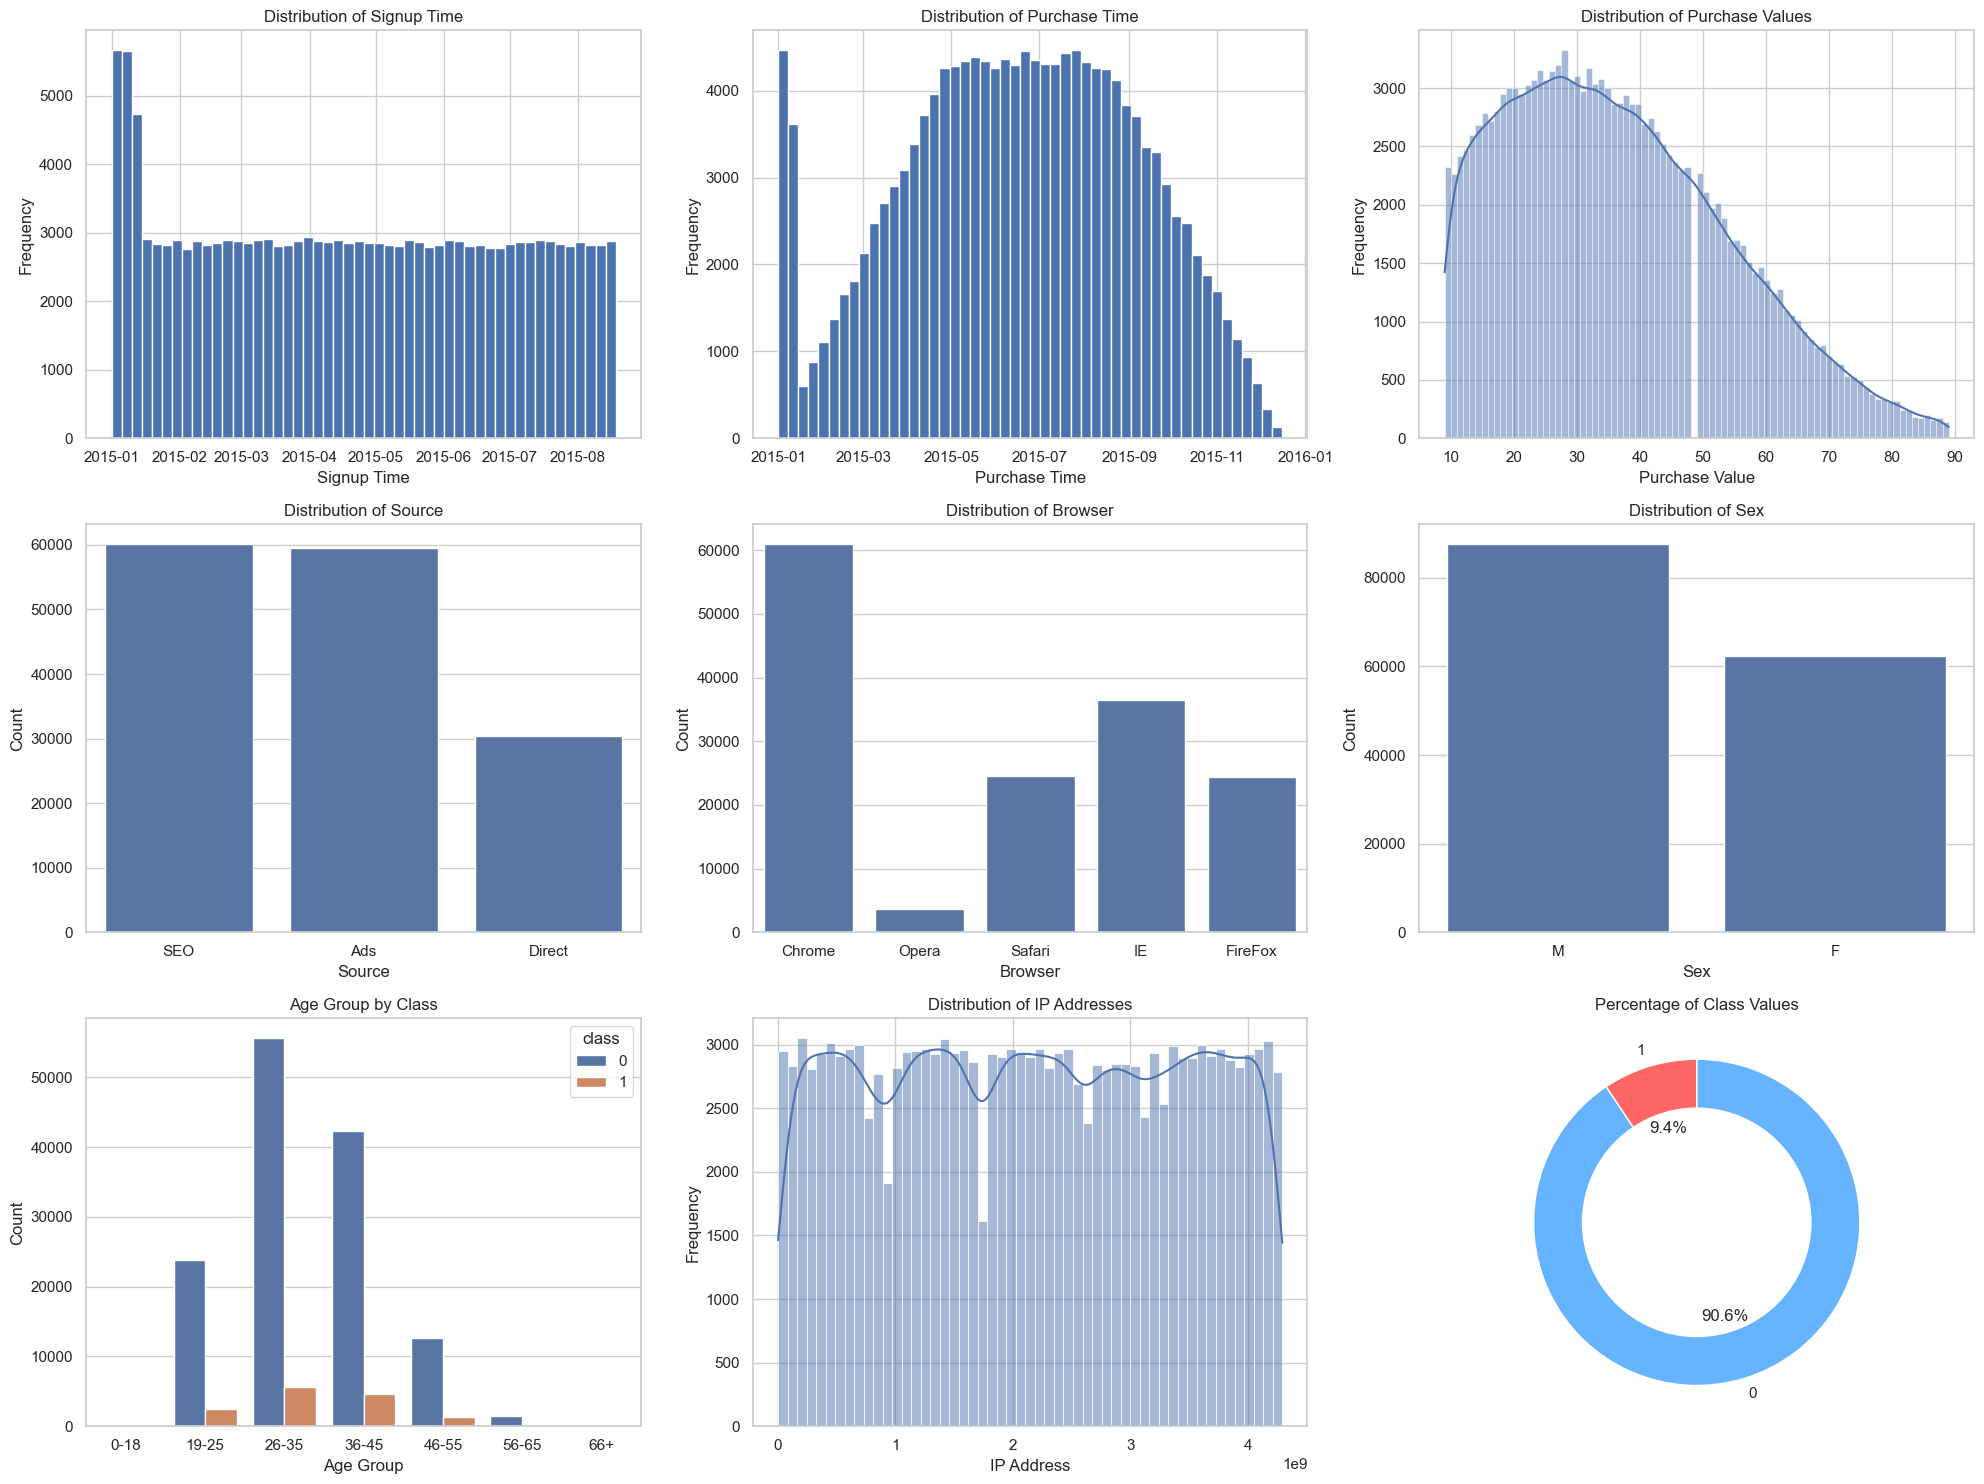

In [13]:
# Define age groups
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Convert relevant columns to datetime
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

# Create subplots for univariate analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

# Plot distribution of signup_time
data['signup_time'].hist(bins=50, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Signup Time')
axes[0, 0].set_xlabel('Signup Time')
axes[0, 0].set_ylabel('Frequency')

# Plot distribution of purchase_time
data['purchase_time'].hist(bins=50, ax=axes[0, 1])
axes[0, 1].set_title('Distribution of Purchase Time')
axes[0, 1].set_xlabel('Purchase Time')
axes[0, 1].set_ylabel('Frequency')

# Plot distribution of purchase_value
sns.histplot(data['purchase_value'], kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Distribution of Purchase Values')
axes[0, 2].set_xlabel('Purchase Value')
axes[0, 2].set_ylabel('Frequency')

# Plot distribution of source
sns.countplot(x='source', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Distribution of Source')
axes[1, 0].set_xlabel('Source')
axes[1, 0].set_ylabel('Count')

# Plot distribution of browser
sns.countplot(x='browser', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Distribution of Browser')
axes[1, 1].set_xlabel('Browser')
axes[1, 1].set_ylabel('Count')

# Plot distribution of sex
sns.countplot(x='sex', data=data, ax=axes[1, 2])
axes[1, 2].set_title('Distribution of Sex')
axes[1, 2].set_xlabel('Sex')
axes[1, 2].set_ylabel('Count')

# Plot age_group vs. class
sns.countplot(x='age_group', hue='class', data=data, ax=axes[2, 0])
axes[2, 0].set_title('Age Group by Class')
axes[2, 0].set_xlabel('Age Group')
axes[2, 0].set_ylabel('Count')

# Plot distribution of ip_address
sns.histplot(data['ip_address'], kde=True, ax=axes[2, 1])
axes[2, 1].set_title('Distribution of IP Addresses')
axes[2, 1].set_xlabel('IP Address')
axes[2, 1].set_ylabel('Frequency')

# Plot distribution of class
class_counts = data['class'].value_counts()
class_percentages = class_counts / class_counts.sum() * 100
axes[2, 2].pie(class_percentages, labels=class_percentages.index, autopct='%1.1f%%', startangle=90, counterclock=False, colors=['#66b3ff','#ff6666'])
centre_circle = plt.Circle((0,0),0.70,fc='white')
axes[2, 2].add_artist(centre_circle)
axes[2, 2].set_title('Percentage of Class Values')

plt.tight_layout()
plt.show()

Bivariate analysis 

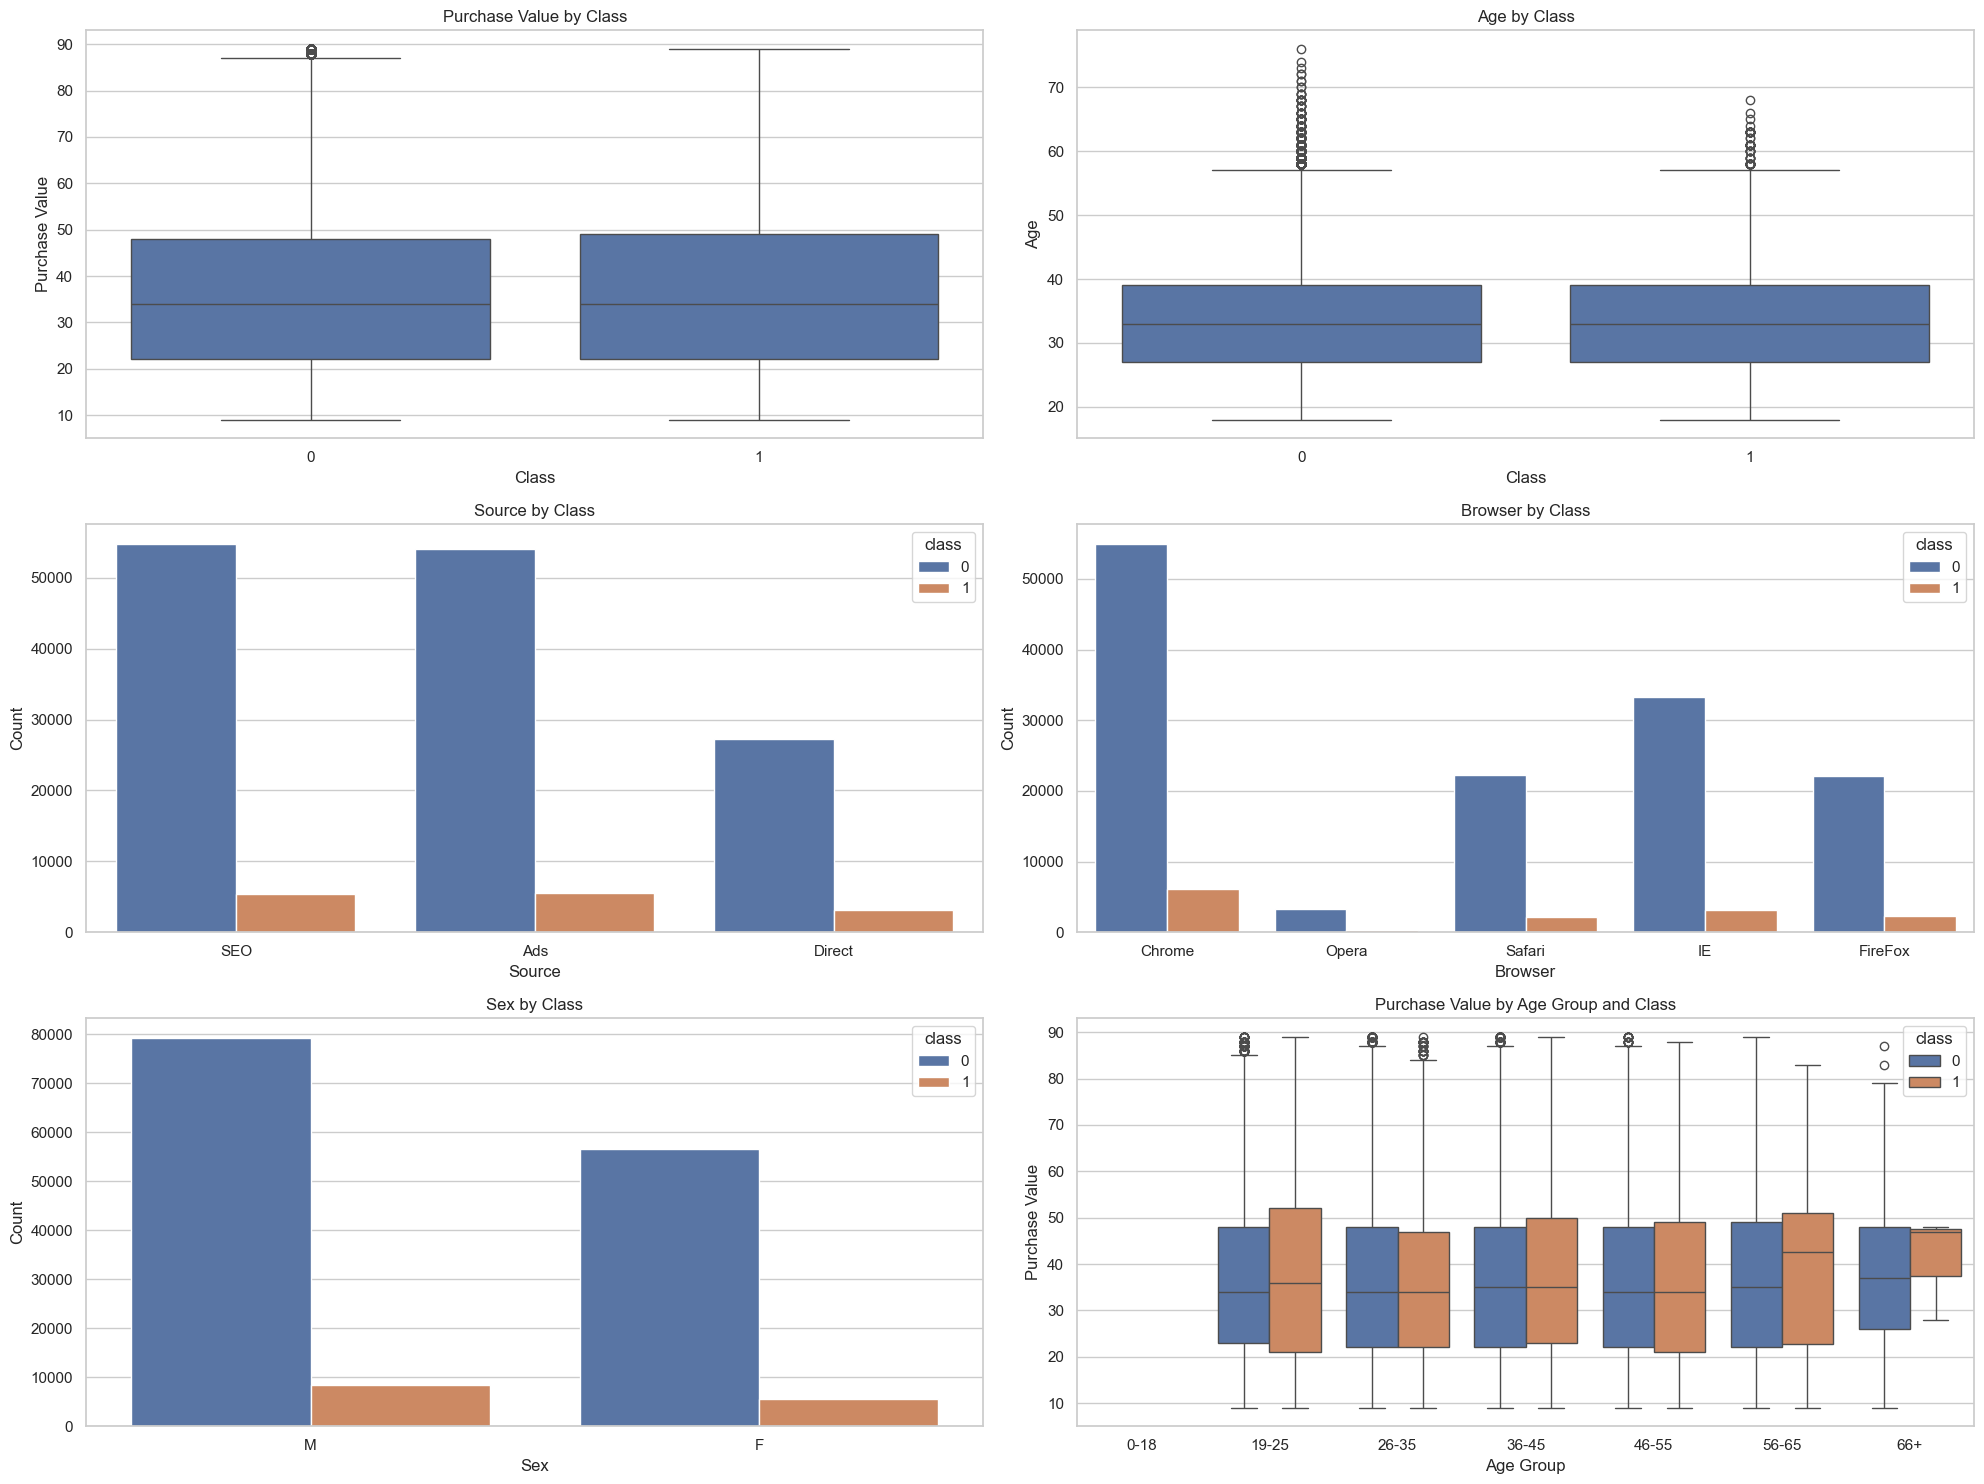

In [14]:
# Define age groups
bins = [0, 18, 25, 35, 45, 55, 65, 100]
labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Create subplots for bivariate analysis
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Plot purchase_value vs. class
sns.boxplot(x='class', y='purchase_value', data=data, ax=axes[0, 0])
axes[0, 0].set_title('Purchase Value by Class')
axes[0, 0].set_xlabel('Class')
axes[0, 0].set_ylabel('Purchase Value')

# Plot age vs. class
sns.boxplot(x='class', y='age', data=data, ax=axes[0, 1])
axes[0, 1].set_title('Age by Class')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Age')

# Plot source vs. class
sns.countplot(x='source', hue='class', data=data, ax=axes[1, 0])
axes[1, 0].set_title('Source by Class')
axes[1, 0].set_xlabel('Source')
axes[1, 0].set_ylabel('Count')

# Plot browser vs. class
sns.countplot(x='browser', hue='class', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Browser by Class')
axes[1, 1].set_xlabel('Browser')
axes[1, 1].set_ylabel('Count')

# Plot sex vs. class
sns.countplot(x='sex', hue='class', data=data, ax=axes[2, 0])
axes[2, 0].set_title('Sex by Class')
axes[2, 0].set_xlabel('Sex')
axes[2, 0].set_ylabel('Count')

# Plot purchase_value vs. age_group
sns.boxplot(x='age_group', y='purchase_value', hue='class', data=data, ax=axes[2, 1])
axes[2, 1].set_title('Purchase Value by Age Group and Class')
axes[2, 1].set_xlabel('Age Group')
axes[2, 1].set_ylabel('Purchase Value')

plt.tight_layout()
plt.show()

5. Merge Datasets for Geolocation Analysis

In [15]:
# Load the IP address to country dataset
ip_data = pd.read_csv('../../src/data/IpAddress_to_Country.csv')

# Ensure IP addresses in ip_data are integers
ip_data['lower_bound_ip_address'] = ip_data['lower_bound_ip_address'].astype(int)
ip_data['upper_bound_ip_address'] = ip_data['upper_bound_ip_address'].astype(int)

# Convert IP addresses in data to integer format for comparison
data['ip_address_int'] = data['ip_address'].astype(float).astype(int)

# Initialize an empty DataFrame to store the merged data
merged_data = []

# Merge based on IP address range
for index, row in data.iterrows():
    ip_address_value = row['ip_address_int']
    matched_country = ip_data[(ip_data['lower_bound_ip_address'] <= ip_address_value) & (ip_data['upper_bound_ip_address'] >= ip_address_value)]
    if not matched_country.empty:
        row['country'] = matched_country['country'].values[0]
    else:
        row['country'] = 'Unknown'
    merged_data.append(row)

# Update the original data DataFrame
data = pd.DataFrame(merged_data)

# Display the first few rows of the merged data
print("\nMerged data:")
data.head()


Merged data:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,age_group,ip_address_int,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,36-45,732758368,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,46-55,350311387,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,46-55,2621473820,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,36-45,3840542443,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39.0,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,46-55,415583117,United States


In [16]:
# Calculate the count of each class
class_counts = data['class'].value_counts()

# Calculate the percentage of each class
class_percentages = (class_counts / class_counts.sum()) * 100

# Print the percentage of each class
print("\nPercentage of Class in Merged Data:")
print(class_percentages)
print(f"Merged data size: {data.shape}")


Percentage of Class in Merged Data:
class
0    90.63481
1     9.36519
Name: count, dtype: float64
Merged data size: (150045, 14)


Total number of unique countries

In [17]:
# Calculate the total number of unique countries
total_countries = data['country'].nunique()

# Display the total number of unique countries
print(f"Total number of unique countries in the dataset: {total_countries}")

Total number of unique countries in the dataset: 182


Top Ten Countries by Class

C:\Users\Abeni\AppData\Local\Temp\ipykernel_7748\2319173917.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


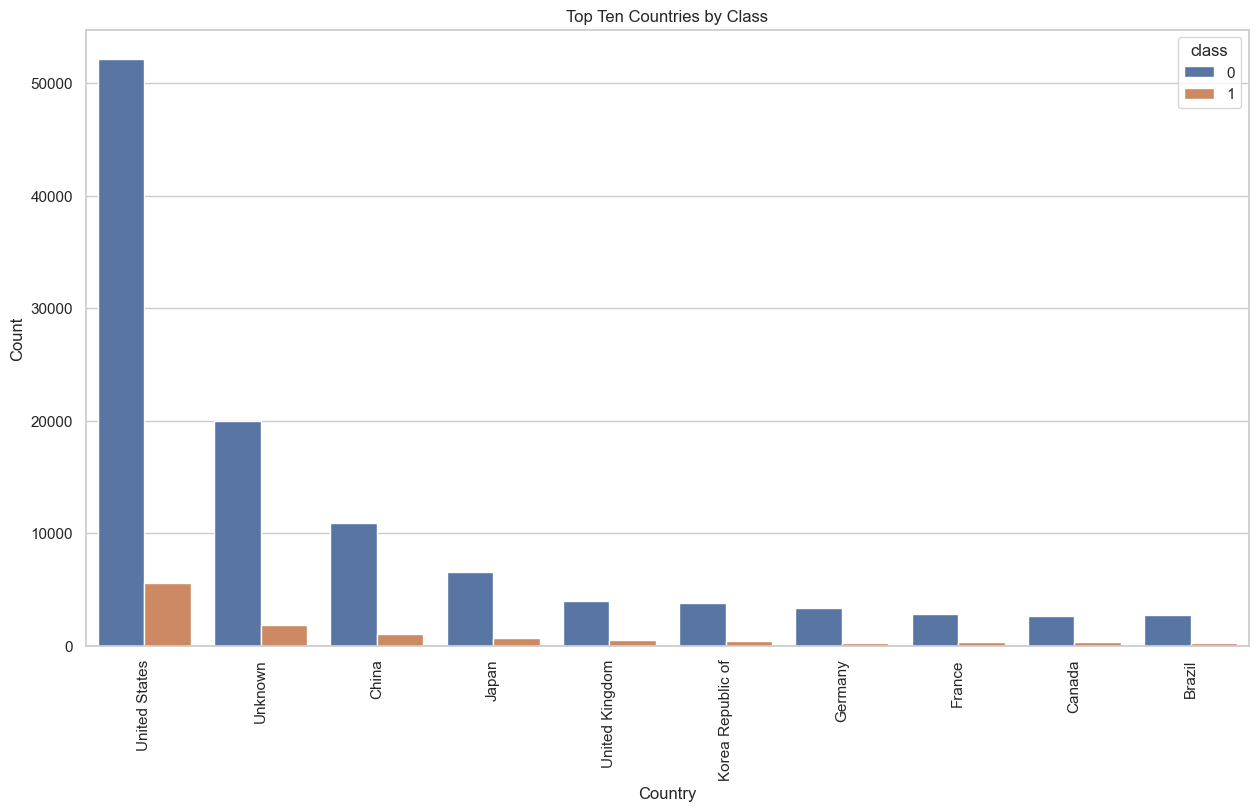

In [18]:
# Calculate the count of each class by country
country_class_distribution = data.groupby(['country', 'class']).size().unstack(fill_value=0)

# Sort the table by the total count of each country in descending order
country_class_distribution['Total'] = country_class_distribution.sum(axis=1)
country_class_distribution = country_class_distribution.sort_values(by='Total', ascending=False)

# Select the top ten countries
top_ten_countries = country_class_distribution.head(10).drop(columns=['Total'])

# Filter the data to include only top ten countries
top_ten_data = data[data['country'].isin(top_ten_countries.index)]

# Plot top ten countries by class
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='country', hue='class', data=top_ten_data, order=top_ten_countries.index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Top Ten Countries by Class')
plt.xlabel('Country')
plt.ylabel('Count')
plt.show()

C:\Users\Abeni\AppData\Local\Temp\ipykernel_7748\3932206524.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Fraud Rate (%)', data=visualization_data, palette='viridis', ax=ax1)
C:\Users\Abeni\AppData\Local\Temp\ipykernel_7748\3932206524.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


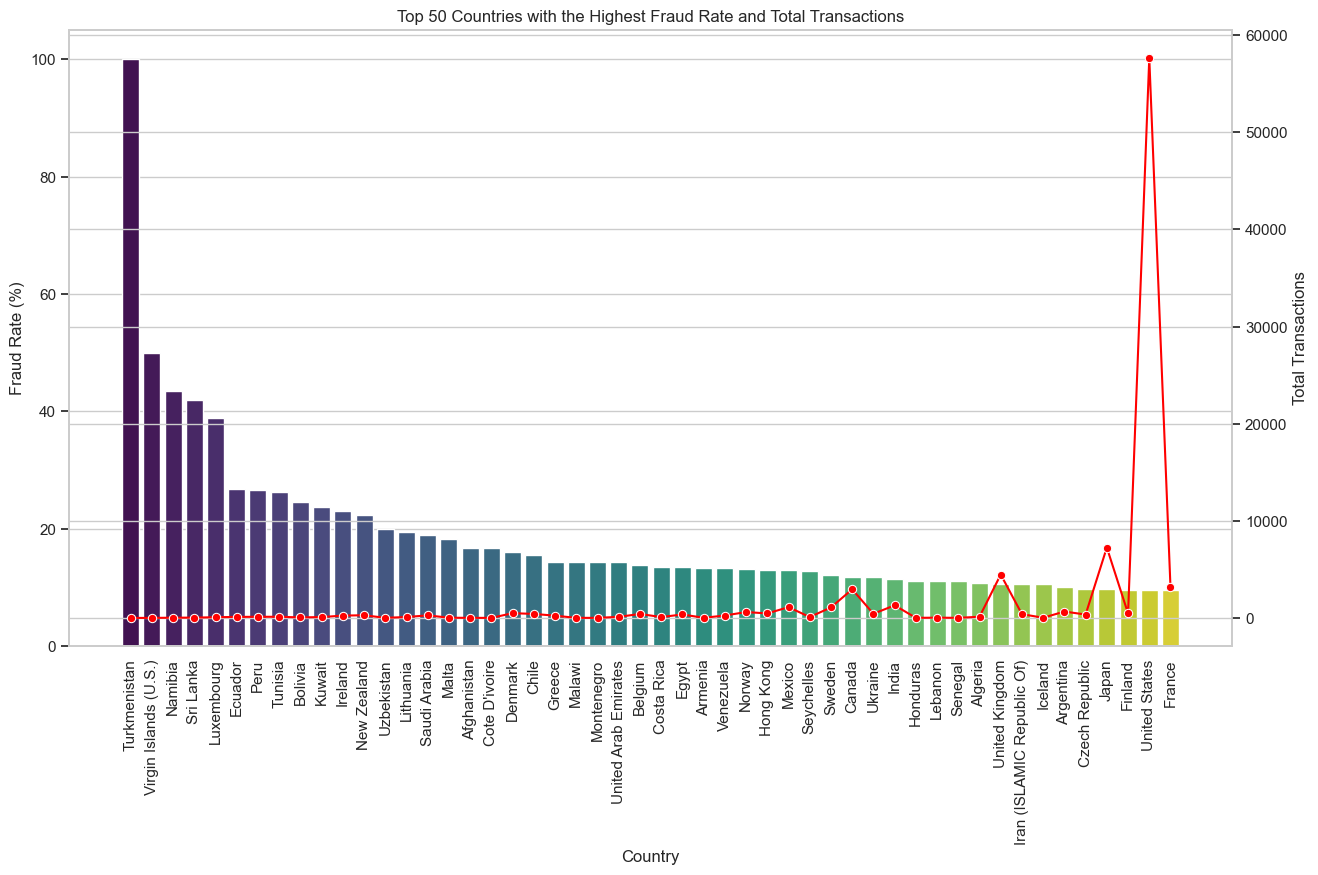


Table: Top 50 Countries with the Highest Fraud Rate and Total Transactions
                       Country  Fraud Rate (%)  Total Transactions
0                 Turkmenistan      100.000000                   1
1        Virgin Islands (U.S.)       50.000000                   2
2                      Namibia       43.478261                  23
3                    Sri Lanka       41.935484                  31
4                   Luxembourg       38.888889                  72
5                      Ecuador       26.666667                 105
6                         Peru       26.495726                 117
7                      Tunisia       26.271186                 118
8                      Bolivia       24.528302                  53
9                       Kuwait       23.595506                  89
10                     Ireland       23.012552                 239
11                 New Zealand       22.382671                 277
12                  Uzbekistan       20.000000       

In [19]:
# Calculate the total number of transactions by country
total_transactions_by_country = data['country'].value_counts()

# Calculate the number of fraudulent transactions by country
fraud_transactions_by_country = data[data['class'] == 1]['country'].value_counts()

# Calculate the fraud rate for each country
fraud_rate_by_country = (fraud_transactions_by_country / total_transactions_by_country) * 100

# Select the top 50 countries with the highest fraud rate
top_50_fraud_rate_countries = fraud_rate_by_country.nlargest(50)

# Calculate the total transactions for the top 50 countries
total_transactions_top_50 = total_transactions_by_country[top_50_fraud_rate_countries.index]

# Create a DataFrame for visualization
visualization_data = pd.DataFrame({
    'Country': top_50_fraud_rate_countries.index,
    'Fraud Rate (%)': top_50_fraud_rate_countries.values,
    'Total Transactions': total_transactions_top_50.values
})

# Plot the fraud rate and total transactions side by side
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot the fraud rate
sns.barplot(x='Country', y='Fraud Rate (%)', data=visualization_data, palette='viridis', ax=ax1)
ax1.set_title('Top 50 Countries with the Highest Fraud Rate and Total Transactions')
ax1.set_xlabel('Country')
ax1.set_ylabel('Fraud Rate (%)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Create a second y-axis for the total transactions
ax2 = ax1.twinx()
sns.lineplot(x='Country', y='Total Transactions', data=visualization_data, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Total Transactions')

plt.show()

# Create a DataFrame for visualization
visualization_data = pd.DataFrame({
    'Country': top_50_fraud_rate_countries.index,
    'Fraud Rate (%)': top_50_fraud_rate_countries.values,
    'Total Transactions': total_transactions_top_50.values
})

# Display the table
print("\nTable: Top 50 Countries with the Highest Fraud Rate and Total Transactions")
print(visualization_data)

C:\Users\Abeni\AppData\Local\Temp\ipykernel_7748\982053320.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Purchase Value Range', y='Fraud Rate (%)', data=value_range_data, palette='viridis', ax=axes[0])
C:\Users\Abeni\AppData\Local\Temp\ipykernel_7748\982053320.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Age Group', y='Fraud Rate (%)', data=age_group_data, palette='viridis', ax=axes[1])
C:\Users\Abeni\AppData\Local\Temp\ipykernel_7748\982053320.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='Fraud Rate (

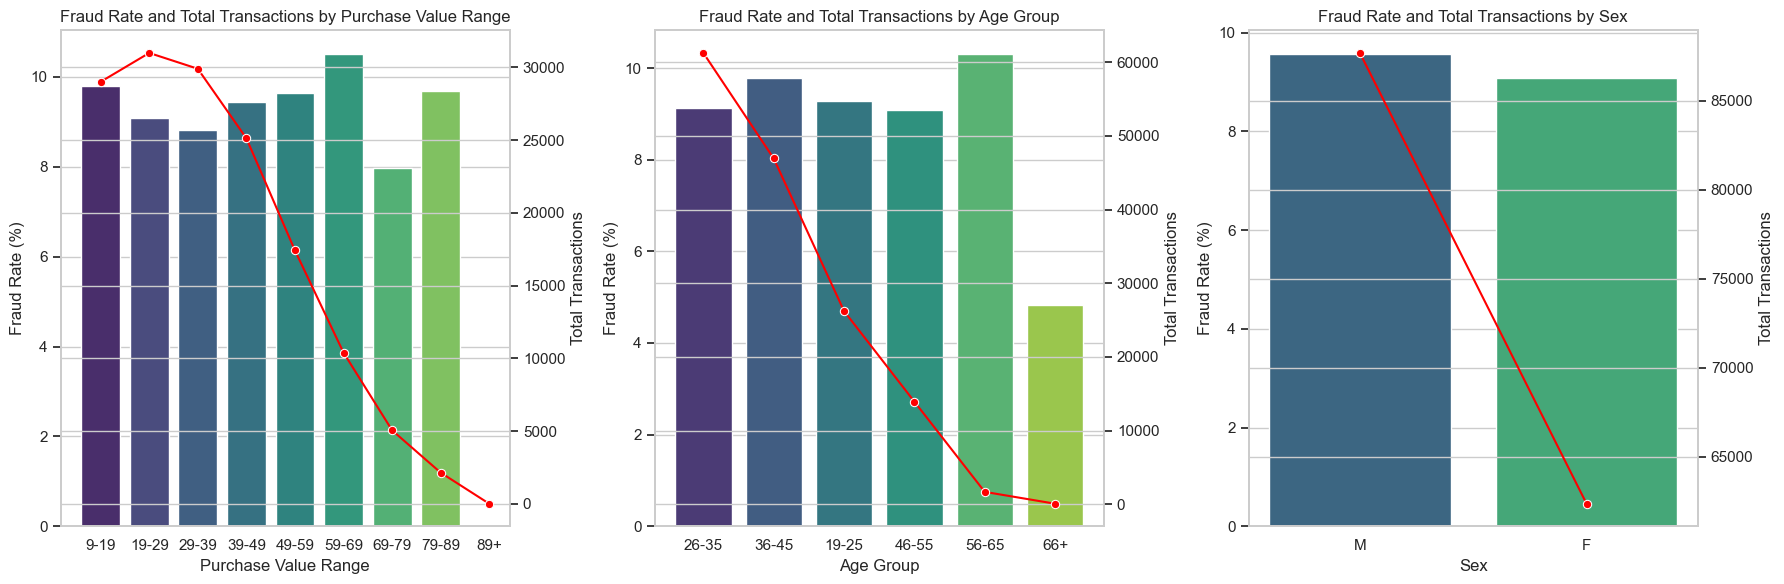


Table: Fraud Rate and Total Transactions by Purchase Value Range
  Purchase Value Range  Fraud Rate (%)  Total Transactions
0                 9-19        9.802502               29013
1                19-29        9.078298               30997
2                29-39        8.816744               29909
3                39-49        9.446500               25131
4                49-59        9.651490               17417
5                59-69       10.509094               10391
6                69-79        7.981779                5049
7                79-89        9.681946                2138
8                  89+             NaN                   0

Table: Fraud Rate and Total Transactions by Age Group
  Age Group  Fraud Rate (%)  Total Transactions
0     26-35        9.123557               61259
1     36-45        9.784577               46931
2     19-25        9.274024               26213
3     46-55        9.093523               13911
4     56-65       10.305572                1669
5

In [20]:
# Ensure 'purchase_value' contains only numeric values and handle NaN values
data['purchase_value'] = pd.to_numeric(data['purchase_value'], errors='coerce')
data = data.dropna(subset=['purchase_value'])

# Define bins with a 10-unit interval for purchase_value
min_value = int(data['purchase_value'].min())
max_value = int(data['purchase_value'].max()) + 1
bins = list(range(min_value, max_value, 10)) + [max_value]
labels = [f"{i}-{i+10}" for i in bins[:-2]] + [f"{bins[-2]}+"]
data['purchase_value_range'] = pd.cut(data['purchase_value'], bins=bins, labels=labels, include_lowest=True)

# Calculate the total number of transactions and fraudulent transactions by purchase_value range
total_transactions_by_value_range = data['purchase_value_range'].value_counts()
fraud_transactions_by_value_range = data[data['class'] == 1]['purchase_value_range'].value_counts()

# Calculate the fraud rate for each purchase_value range
fraud_rate_by_value_range = (fraud_transactions_by_value_range / total_transactions_by_value_range) * 100

# Calculate the total number of transactions and fraudulent transactions by age group
total_transactions_by_age_group = data['age_group'].value_counts()
fraud_transactions_by_age_group = data[data['class'] == 1]['age_group'].value_counts()
fraud_rate_by_age_group = (fraud_transactions_by_age_group / total_transactions_by_age_group) * 100

# Calculate the total number of transactions and fraudulent transactions by sex
total_transactions_by_sex = data['sex'].value_counts()
fraud_transactions_by_sex = data[data['class'] == 1]['sex'].value_counts()
fraud_rate_by_sex = (fraud_transactions_by_sex / total_transactions_by_sex) * 100

# Create DataFrames for visualization
value_range_data = pd.DataFrame({
    'Purchase Value Range': fraud_rate_by_value_range.index,
    'Fraud Rate (%)': fraud_rate_by_value_range.values,
    'Total Transactions': total_transactions_by_value_range[fraud_rate_by_value_range.index].values
})

age_group_data = pd.DataFrame({
    'Age Group': fraud_rate_by_age_group.index,
    'Fraud Rate (%)': fraud_rate_by_age_group.values,
    'Total Transactions': total_transactions_by_age_group[fraud_rate_by_age_group.index].values
})

sex_data = pd.DataFrame({
    'Sex': fraud_rate_by_sex.index,
    'Fraud Rate (%)': fraud_rate_by_sex.values,
    'Total Transactions': total_transactions_by_sex[fraud_rate_by_sex.index].values
})

# Create the figure and axes for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the fraud rate and total transactions by purchase value range
sns.barplot(x='Purchase Value Range', y='Fraud Rate (%)', data=value_range_data, palette='viridis', ax=axes[0])
axes[0].set_title('Fraud Rate and Total Transactions by Purchase Value Range')
axes[0].set_xlabel('Purchase Value Range')
axes[0].set_ylabel('Fraud Rate (%)')
ax2 = axes[0].twinx()
sns.lineplot(x='Purchase Value Range', y='Total Transactions', data=value_range_data, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Total Transactions')

# Plot the fraud rate and total transactions by age group
sns.barplot(x='Age Group', y='Fraud Rate (%)', data=age_group_data, palette='viridis', ax=axes[1])
axes[1].set_title('Fraud Rate and Total Transactions by Age Group')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Fraud Rate (%)')
ax2 = axes[1].twinx()
sns.lineplot(x='Age Group', y='Total Transactions', data=age_group_data, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Total Transactions')

# Plot the fraud rate and total transactions by sex
sns.barplot(x='Sex', y='Fraud Rate (%)', data=sex_data, palette='viridis', ax=axes[2])
axes[2].set_title('Fraud Rate and Total Transactions by Sex')
axes[2].set_xlabel('Sex')
axes[2].set_ylabel('Fraud Rate (%)')
ax2 = axes[2].twinx()
sns.lineplot(x='Sex', y='Total Transactions', data=sex_data, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Total Transactions')

plt.tight_layout()
plt.show()

# Display the tables
print("\nTable: Fraud Rate and Total Transactions by Purchase Value Range")
print(value_range_data)
print("\nTable: Fraud Rate and Total Transactions by Age Group")
print(age_group_data)
print("\nTable: Fraud Rate and Total Transactions by Sex")
print(sex_data)

6. Feature Engineering

In [21]:
# Create transaction frequency and velocity features
data['transaction_count'] = data.groupby('user_id')['user_id'].transform('count')
data['transaction_velocity'] = data['transaction_count'] / ((pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time'])).dt.total_seconds() + 1)

# Create time-based features
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['hour_of_day'] = data['purchase_time'].dt.hour
data['day_of_week'] = data['purchase_time'].dt.dayofweek

# Display the first few rows with new features
print("\nData with new features:")
data.head()


Data with new features:


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,age_group,ip_address_int,country,purchase_value_range,transaction_count,transaction_velocity,hour_of_day,day_of_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34.0,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,36-45,732758368,Japan,29-39,1,2.218927e-07,2,5
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16.0,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,46-55,350311387,United States,9-19,1,5.572583e-05,1,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15.0,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,46-55,2621473820,United States,9-19,1,5.000000e-01,18,3
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44.0,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,36-45,3840542443,Unknown,39-49,1,2.032165e-06,13,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39.0,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,46-55,415583117,United States,29-39,1,2.292809e-07,18,2


7. Normalization and Scaling

In [22]:
# Check for missing values in the entire DataFrame
missing_values = data.isnull().sum()

# Display columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
Series([], dtype: int64)


In [23]:
# Define numerical columns excluding 'day_of_week'
numerical_columns = ['purchase_value', 'age', 'ip_address_int', 'transaction_count', 'transaction_velocity', 'hour_of_day']

# Scale the numerical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Fit and transform the numerical columns
data[numerical_columns] = numerical_transformer.fit_transform(data[numerical_columns])

# Display the normalized and scaled data
data[numerical_columns].head()

,purchase_value,age,ip_address_int,transaction_count,transaction_velocity,hour_of_day
0,-0.141925,0.679943,-1.136880,0.0,-0.230126,-1.377541
1,-1.161896,2.304808,-1.443193,0.0,-0.229619,-1.522217
2,-1.218561,2.304808,0.375847,0.0,4.345577,0.937274
3,0.424725,0.912066,1.352235,0.0,-0.230110,0.213894
4,0.141400,1.376313,-1.390915,0.0,-0.230126,0.937274


8. Encode Categorical Features

In [24]:
# Define specified categorical columns
categorical_columns = ['sex', 'country', 'purchase_value_range', 'age_group', 'day_of_week']

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Encode each categorical column using LabelEncoder
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])

# Display the updated DataFrame
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,age_group,ip_address_int,country,purchase_value_range,transaction_count,transaction_velocity,hour_of_day,day_of_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,-0.141925,QVPSPJUOCKZAR,SEO,Chrome,1,0.679943,7.327584e+08,0,2,-1.136880,84,1,0.0,-0.230126,-1.377541,5
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,-1.161896,EOGFQPIZPYXFZ,Ads,Chrome,0,2.304808,3.503114e+08,0,3,-1.443193,171,7,0.0,-0.229619,-1.522217,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,-1.218561,YSSKYOSJHPPLJ,SEO,Opera,1,2.304808,2.621474e+09,1,3,0.375847,171,7,0.0,4.345577,0.937274,3
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,0.424725,ATGTXKYKUDUQN,SEO,Safari,1,0.912066,3.840542e+09,0,2,1.352235,172,2,0.0,-0.230110,0.213894,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,0.141400,NAUITBZFJKHWW,Ads,Safari,1,1.376313,4.155831e+08,0,3,-1.390915,171,1,0.0,-0.230126,0.937274,2


9. Final Code to Drop Unnecessary Columns and Save Data

In [25]:
# Define the columns that you want to drop
columns_to_drop = ['signup_time', 'purchase_time', 'ip_address', 'user_id', 'device_id', 'source', 'browser']

# Drop the unnecessary columns
data = data.drop(columns=columns_to_drop)

# Save the final processed data to the specified path
data.to_csv('../../src/data/e-commerce_processed_data.csv', index=False)

# Display a message indicating the data has been saved
print("e-commerce processed data has been saved to '../../src/data/e-commerce_processed_data.csv'.")

e-commerce processed data has been saved to '../../src/data/e-commerce_processed_data.csv'.


In [27]:
data.shape

(150045, 12)